In [1]:
from keras import optimizers, losses
from keras.models import Sequential,Model
from keras.layers import Dense,Input,Dropout,Embedding,concatenate
from keras.optimizers import RMSprop,Adam,Nadam
from keras.preprocessing import sequence 
from keras.callbacks import TensorBoard
from keras.utils import plot_model

from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pickle 

import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import time 
import sys

Using TensorFlow backend.


In [2]:
# Visualisation class
class Visualization:
    
    labels=["Normal","Anomaly"]
    
    def drow_confusion_matrix(self,y,ypred):
        matrix=confusion_matrix(y,ypred)
        plt.figure(figsize=(15,10))
        colors=["indianred","lightseagreen"]
        sns.heatmap(matrix,xticklabels=self.labels,yticklabels=self.labels,cmap=colors,annot=True,fmt="d")
        plt.title("confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel("Predicted")
        plt.show()
    
    
    def drow_anomaly(self,y,error,threshold):
        groupsDF=pd.DataFrame({
            "error":error,
            "true":y
        }).groupby("true")
        
        figure , axes= plt.subplots(figsize=(12,8))
        for name,group in groupsDF:
            axes.plot(
                      group.index,group.error,marker="x" if name == 1 else "o",linestyle='',
                      color='r' if name==1 else "teal" , label="Anomaly" if name==1 else "Normal"
                     )
            
        axes.hlines(threshold,axes.get_xlim()[0],axes.get_xlim()[1],color="b",zorder=100,label='Thershold')
        axes.legend()
        plt.title("Anomalie")
        plt.xlabel("Data")
        plt.ylabel("Error")
        plt.show()
            
    
    def drow_error(self,error,threshold):
        plt.plot(error,marker="o",ms=3.5,linestyle="",label="Point")
        plt.hlines(threshold,xmin=0,xmax=len(error)-1,colors="b",zorder=100,label="Threshold")
        plt.legend()
        plt.title("Reconstruction Error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
        
            

In [3]:
df =pd.read_csv("../../data/full_data_small_datased.csv")

In [4]:
def transformer_df(df):
    dic={}
    for c in df.columns :
        if (df[c].dtype =="object"):
            encoder = LabelEncoder()
            encoder.fit(df[c])
            df[c]=encoder.transform(df[c])
            dic[c]=encoder
    with open("./models/LabelEncoders_dic.pickle","wb") as f:
        pickle.dump(dic,f)
    return df

In [5]:
from sklearn.utils import shuffle
def shuffle_dataframe(df):
    df = shuffle(df)
    return df

In [6]:
def normaliser_all_columns(df):
    diction={}
    for c in df.columns :
        scaler=MinMaxScaler(feature_range=(0,1)).fit(df[c].values.reshape(-1,1))
        diction[c]=scaler        
        df[c]=scaler.transform(df[c].values.reshape(-1,1))
    with open("./models/MinMaxScalers_dic.pickle","wb") as f:
        pickle.dump(diction,f)
    return df

In [7]:
df=transformer_df(df)
df=normaliser_all_columns(df)
df=shuffle_dataframe(df)

In [8]:
xtrain,xtest,ytrain,ytest=train_test_split(df.drop(labels=["Class"],axis=1),df["Class"],test_size=0.2)

In [9]:
def add_noise(xtrain,xtest,ytrain,ytest):
    noise_factor=0.3
    xtrain_noise=xtrain + noise_factor *np.random.normal(loc=0.0,scale=1.0,size=xtrain.shape)
    xtest_noise=xtest + noise_factor *np.random.normal(loc=0.0,scale=1.0,size=xtest.shape)
    ytrain_noise=ytrain + noise_factor *np.random.normal(loc=0.0,scale=1.0,size=ytrain.shape)
    ytest_noise=ytest + noise_factor *np.random.normal(loc=0.0,scale=1.0,size=ytest.shape)
    xtrain_noise=np.clip(xtrain_noise,0.,1.)
    xtest_noise=np.clip(xtest_noise,0.,1.)
    ytrain_noise=np.clip(ytrain_noise,0.,1.)
    ytest_noise=np.clip(ytest_noise,0.,1.)
    return xtrain_noise,xtest_noise,ytrain_noise,ytest_noise

In [10]:
xtrain_noise,xtest_noise,ytrain_noise,ytest_noise=add_noise(xtrain,xtest,ytrain,ytest)

In [11]:
def create_dae(input_dim):
    
    dae_input=Input(shape=(input_dim,)) #Define the input layer
    
    encoded= Dense(units=input_dim,activation="tanh")(dae_input) 
    encoded= Dense(units=int(input_dim/2),activation="tanh")(encoded) 
    encoded= Dense(units=int(input_dim/4),activation="tanh")(encoded)
    encoded= Dense(units=int(input_dim/8),activation="tanh")(encoded)
    encoded= Dense(units=10,activation="tanh")(encoded)
    encoded= Dense(units=3,activation="tanh")(encoded)
    encoded= Dense(units=int(input_dim/8),activation="tanh")(encoded)
    decoded= Dense(units=int(input_dim/4),activation="tanh")(encoded)
    decoded= Dense(units=int(input_dim/2),activation="tanh")(decoded)
    decoded= Dense(units=input_dim,activation="tanh")(decoded)
    decoded= Dense(units=input_dim,activation="softmax",name='decoded')(decoded) #softmax return a vector of probabilty describing the importance of each attribute 
    autoecoder=Model(dae_input,decoded)# the input layer and the output layer 
    autoecoder.summary()
    autoecoder.compile(optimizer=RMSprop(),loss="mean_squared_error",metrics=["mae"])
    plot_model(autoecoder,to_file='dae.png',show_shapes=True)
    return autoecoder

In [12]:
denosed_autoecoder = create_dae(xtrain.shape[1])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 115)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 115)               13340     
_________________________________________________________________
dense_2 (Dense)              (None, 57)                6612      
_________________________________________________________________
dense_3 (Dense)              (None, 28)                1624      
_________________________________________________________________
dense_4 (Dense)              (None, 14)                406       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                150       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 33  

In [13]:
#hyperparametrs :
batchsize=100
epoch=10
start_time = time.time() 
denosed_autoecoder.fit(xtrain_noise,xtrain,
              batch_size=batchsize,
              epochs=epoch,
              verbose=1,
              shuffle=True,
              validation_data=(xtest_noise,xtest),
              callbacks=[TensorBoard(log_dir="../logs/Denoiseautoencoder")])
print("--- %s seconds ---" % (time.time() - start_time))

Train on 222448 samples, validate on 55612 samples
Epoch 1/10
222448/222448 [==============================] - 6s 27us/step - loss: 0.2767 - mae: 0.3581 - val_loss: 0.2767 - val_mae: 0.3583
Epoch 2/10
222448/222448 [==============================] - 5s 24us/step - loss: 0.2766 - mae: 0.3581 - val_loss: 0.2767 - val_mae: 0.3583
Epoch 3/10
222448/222448 [==============================] - 5s 24us/step - loss: 0.2766 - mae: 0.3581 - val_loss: 0.2768 - val_mae: 0.3583
Epoch 4/10
222448/222448 [==============================] - 5s 25us/step - loss: 0.2766 - mae: 0.3581 - val_loss: 0.2763 - val_mae: 0.3583
Epoch 5/10
222448/222448 [==============================] - 6s 26us/step - loss: 0.2761 - mae: 0.3581 - val_loss: 0.2762 - val_mae: 0.3583
Epoch 6/10
222448/222448 [==============================] - 6s 27us/step - loss: 0.2761 - mae: 0.3581 - val_loss: 0.2762 - val_mae: 0.3583
Epoch 7/10
222448/222448 [==============================] - 6s 27us/step - loss: 0.2761 - mae: 0.3581 - val_loss: 0

In [14]:
%load_ext tensorboard
%tensorboard --logdir {"../logs/Denoiseautoencoder/"}

### View the avrage length distribution of normal data

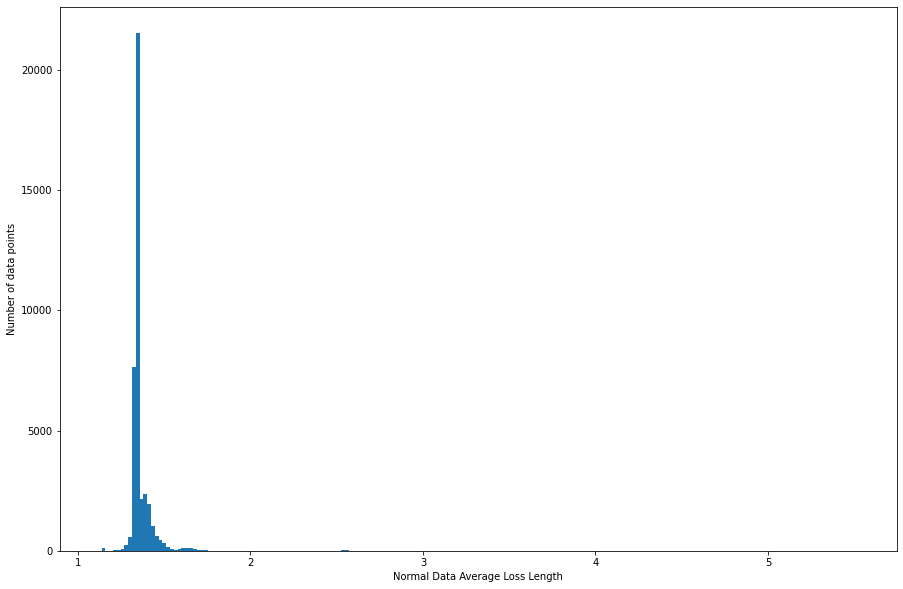

In [21]:
normal_data=df[df["Class"]==0].drop("Class",axis=1)
y_pred=denosed_autoecoder.predict(normal_data) # predicter les nouvelles transactions 
y_dist=np.linalg.norm(normal_data-y_pred,axis=-1) # calculer la distance entre la valeur reel et la valeur predicter 

plt.figure(figsize=(15,10))
plt.hist(y_dist,bins=200)
plt.xlabel("Normal Data Average Loss Length")
plt.ylabel("Number of data points")
plt.show()

### View the avrage length distribution of anomalie data

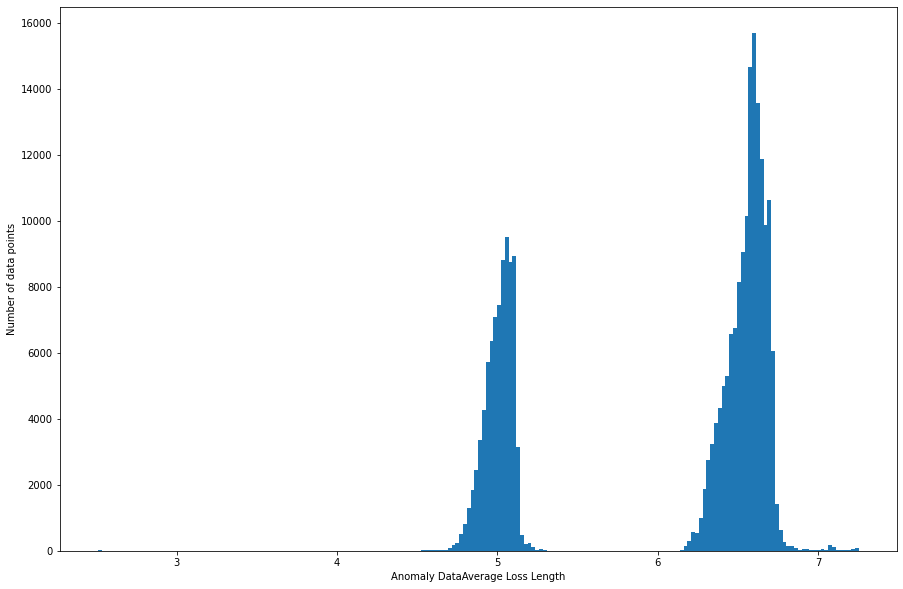

In [22]:
anomalie_data=df[df["Class"]==1].drop("Class",axis=1)
y_pred=denosed_autoecoder.predict(anomalie_data) # predicter les nouvelles transactions 
y_dist=np.linalg.norm(anomalie_data-y_pred,axis=-1) # calculer la distance entre la valeur reel et la valeur predicter 
plt.figure(figsize=(15,10))
plt.hist(y_dist,bins=200)
plt.xlabel("Anomaly DataAverage Loss Length")
plt.ylabel("Number of data points")
plt.show()

### View the avrage length distribution of xtest data


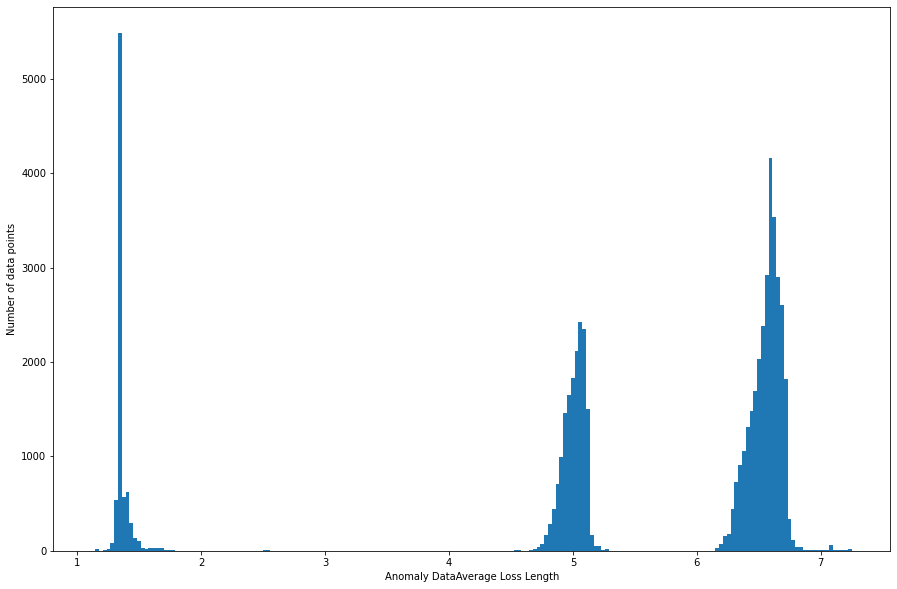

In [23]:
y_pred=denosed_autoecoder.predict(xtest) # predicter les nouvelles transactions 
y_dist=np.linalg.norm(xtest-y_pred,axis=-1) # calculer la distance entre la valeur reel et la valeur predicter 
plt.figure(figsize=(15,10))
plt.hist(y_dist,bins=200)
plt.xlabel("Anomaly DataAverage Loss Length")
plt.ylabel("Number of data points")
plt.show()

In [15]:
def prediction(xtest):
    threshold=2.8 # le maximu distance possible pour ne considere pas comme anomalie
    start_time = time.time() 
    y_pred=denosed_autoecoder.predict(xtest) # predicter les nouvelles transactions 
    print("--- %s seconds ---" % (time.time() - start_time))    
    y_dist=np.linalg.norm(xtest-y_pred,axis=-1) # calculer la distance entre la valeur reel et la valeur predicter 
    z=zip(y_dist >= threshold , y_dist)# retourner un tableau de True , False si ladistance superieur au threshold ou non 
    y_label=[]
    error=[]
# cree un array des 1 et 0 si anomaly ou non  
    for idx ,(is_anomaly , y_dist) in enumerate(z):
        if is_anomaly : # if the value is True : which mean the distance is sup then the threshold 
            y_label.append(1)
        else:
            y_label.append(0)
        error.append(y_dist)
    return y_label

## Evaluer lalgorithme avec xtest

In [16]:
y_pred=prediction(xtest)

--- 0.8973708152770996 seconds ---


In [17]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7989
         1.0       1.00      1.00      1.00     47623

    accuracy                           1.00     55612
   macro avg       1.00      1.00      1.00     55612
weighted avg       1.00      1.00      1.00     55612



In [18]:
print('precision_score : '+str(precision_score(ytest, y_pred, average='weighted')))
print('accuracy_score : '+str(accuracy_score(ytest, y_pred)))
print('recall_score : '+str(recall_score(ytest, y_pred, average='weighted')))
print('f1_score : '+str(f1_score(ytest, y_pred, average='weighted')))
print('roc_auc_score : '+str(roc_auc_score(ytest,y_pred))) # TruePositive,TrueNegative
tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
print('True_positive : '+str(tp)+', False_positive : '+str(fp)+', True_negative : '+str(tn)+', False_negative : '+str(fn))

precision_score : 0.9997482560001812
accuracy_score : 0.9997482557721356
recall_score : 0.9997482557721356
f1_score : 0.9997481901584966
roc_auc_score : 0.9992279690729342
True_positive : 47621, False_positive : 12, True_negative : 7977, False_negative : 2


In [19]:
viz=Visualization()

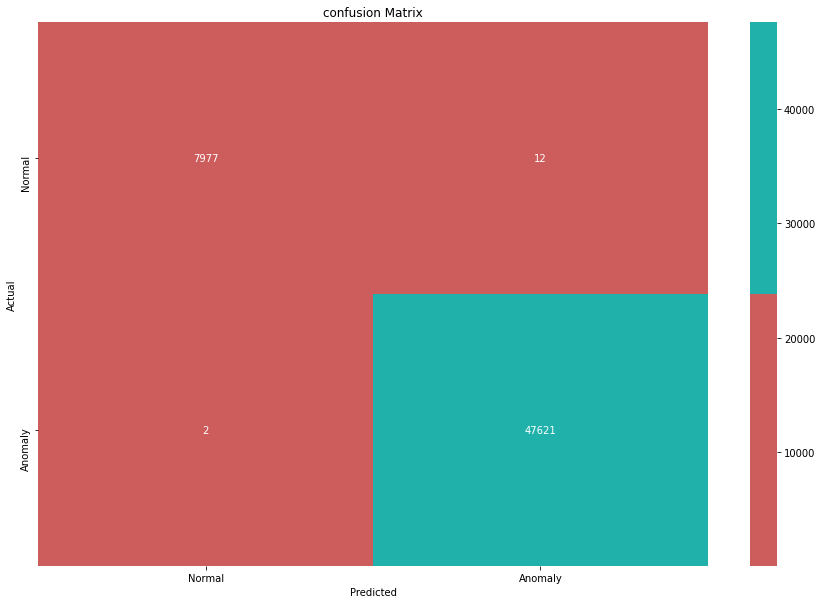

In [20]:
viz.drow_confusion_matrix(ytest,y_pred)

In [34]:
denosed_autoecoder.save("./models/dae.h5")